<a href="https://colab.research.google.com/github/nick11roberts/noise-weight-theft/blob/master/mnist_one_pixel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
'''Trains a simple convnet on the MNIST dataset.

Gets to 99.25% test accuracy after 12 epochs
(there is still a lot of margin for parameter tuning).
16 seconds per epoch on a GRID K520 GPU.
'''

from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

batch_size = 128
num_classes = 10
epochs = 12

# input image dimensions
img_rows, img_cols = 28, 28

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')



##### COMPLEMENT CODE #####
#x_train = 1.0 - x_train
#x_test = 1.0 - x_test
##### /COMPLEMENT CODE ####


# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])


Using TensorFlow backend.


11493376/11490434 [==============================] - 5s 0us/step
x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Train on 60000 samples, validate on 10000 samples
Epoch 1/12
60000/60000 [==============================] - 11s 186us/step - loss: 0.2621 - acc: 0.9192 - val_loss: 0.0598 - val_acc: 0.9808
Epoch 2/12
60000/60000 [==============================] - 4s 73us/step - loss: 0.0895 - acc: 0.9739 - val_loss: 0.0439 - val_acc: 0.9859
Epoch 3/12
60000/60000 [==============================] - 4s 74us/step - loss: 0.0675 - acc: 0.9797 - val_loss: 0.0329 - val_acc: 0.9893
Epoch 4/12
60000/60000 [==============================] - 4s 73us/step - loss: 0.0560 - acc: 0.9834 - val_loss: 0.0302 - val_acc: 0.9895
Epoch 5/12
60000/60000 [===

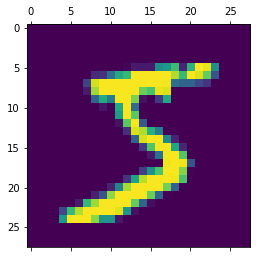

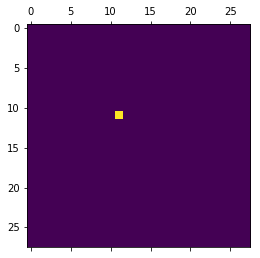

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import scipy

x_example = x_train

plt.matshow(x_example[0, :, :, 0])
plt.show()

pixel_example = np.zeros_like(x_example)
pixel_example[0, 11, 11, 0] = 1.0

plt.matshow(pixel_example[0, :, :, 0])
plt.show()

In [0]:
model.predict(np.expand_dims(pixel_example[0], 0))

array([[0.0695034 , 0.16194046, 0.08120266, 0.08875474, 0.11079603,
        0.08089162, 0.07110448, 0.12898912, 0.08283246, 0.12398513]],
      dtype=float32)

In [0]:
pixel_batch = []

for i in range(28):
  for j in range(28):
    pix_img = np.zeros_like(x_train[0])
    pix_img[i, j, 0] = 1.0 # Could also try random [0, 1] values
    
    pixel_batch.append(pix_img)
    
pixel_batch = np.stack(pixel_batch)

Text(0.5, 1.05, 'Pixel-wise class predictions\n')

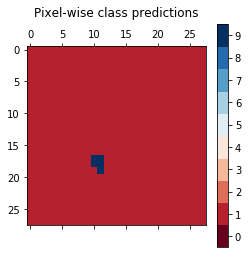

In [0]:
pix_softmax = model.predict(pixel_batch).reshape([28, 28, 10])
pix_predictions = model.predict_classes(pixel_batch).reshape([28, 28])

def discrete_matshow(data):
    #get discrete colormap
    mx = 9
    mn = 0
    cmap = plt.get_cmap('RdBu', mx-mn+1)
    # set limits .5 outside true range
    mat = plt.matshow(data,cmap=cmap,vmin = mn-.5, vmax = mx+.5)
    #tell the colorbar to tick at integers
    cax = plt.colorbar(mat, ticks=np.arange(mn,mx+1))

                       
discrete_matshow(pix_predictions)
plt.title("Pixel-wise class predictions\n")

Text(0.5, 1.05, 'Softmax entropy\n')

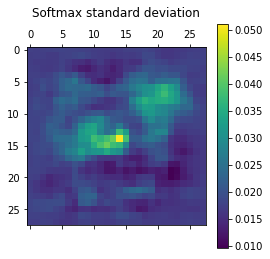

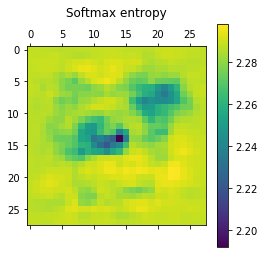

In [0]:
softmax_std = np.std(pix_softmax, axis=2).reshape(28, 28)
softmax_ent = -np.sum(pix_softmax * np.log(pix_softmax), axis=2)

plt.matshow(softmax_std)
plt.colorbar()
plt.title("Softmax standard deviation\n")

plt.matshow(softmax_ent)
plt.colorbar()
plt.title("Softmax entropy\n")

Among each class in isolation, what regions correspond to higher or lower z-scored softmax outputs?
How about when we z-score the outputs globally?


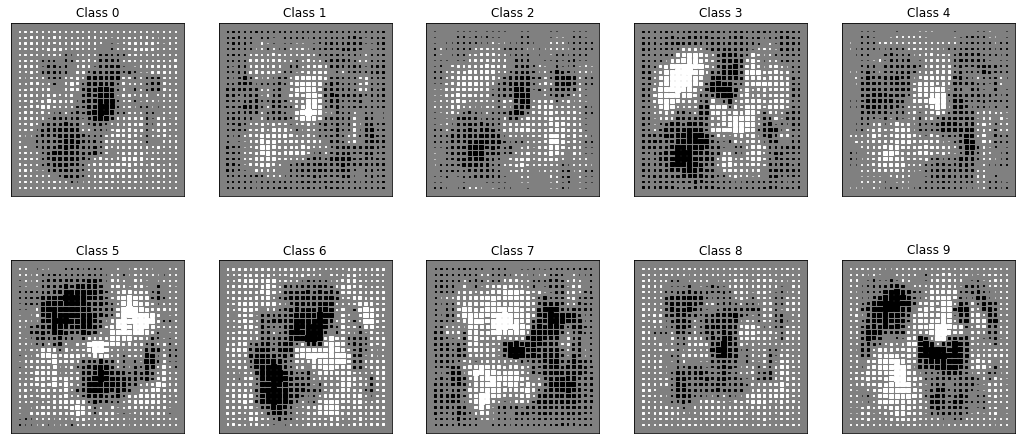

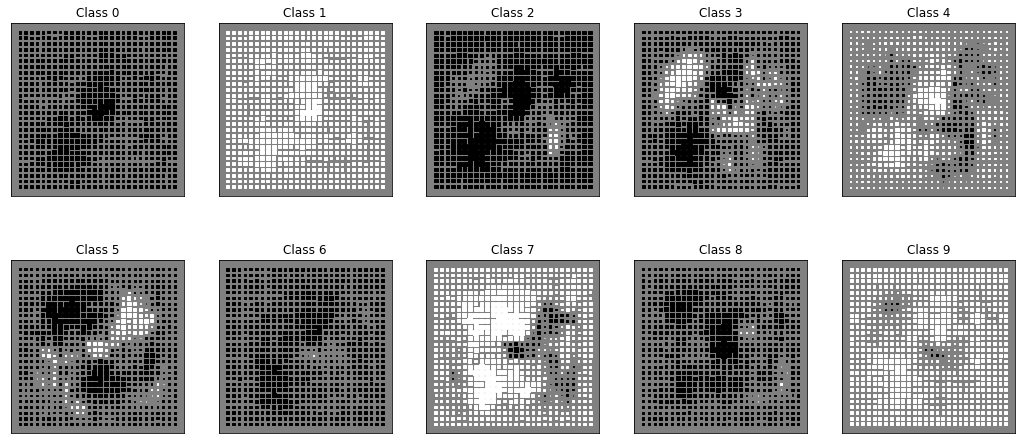

In [0]:
def hinton(matrix, max_weight=None, ax=None):
    """Draw Hinton diagram for visualizing a weight matrix."""
    ax = ax if ax is not None else plt.gca()

    if not max_weight:
        max_weight = 2 ** np.ceil(np.log(np.abs(matrix).max()) / np.log(2))

    ax.patch.set_facecolor('gray')
    ax.set_aspect('equal', 'box')
    ax.xaxis.set_major_locator(plt.NullLocator())
    ax.yaxis.set_major_locator(plt.NullLocator())

    for (x, y), w in np.ndenumerate(matrix):
        color = 'white' if w > 0 else 'black'
        size = np.sqrt(np.abs(w) / max_weight)
        rect = plt.Rectangle([x - size / 2, y - size / 2], size, size,
                             facecolor=color, edgecolor=color)
        ax.add_patch(rect)

    ax.autoscale_view()
    ax.invert_yaxis()
    
def shift_scale(x):
  
  mu = np.mean(x)
  sig = np.std(x)
  
  return (x - mu) / sig
    
print('Among each class in isolation, ' +
      'what regions correspond to higher or lower z-scored softmax outputs?')
fig, ax = plt.subplots(2, 5, figsize=(18, 8))
for i in range(10):
  ax[i // 5, i % 5].set_title('Class {}'.format(i))
  hinton(shift_scale(pix_softmax[:, :, i]), ax=ax[i // 5, i % 5])
  


print('How about when we z-score the outputs globally?')
fig, ax = plt.subplots(2, 5, figsize=(18, 8))
for i in range(10):
  ax[i // 5, i % 5].set_title('Class {}'.format(i))
  hinton((pix_softmax[:, :, i] - np.mean(pix_softmax)) / np.std(pix_softmax), 
         ax=ax[i // 5, i % 5])
  
# Among each class in isolation, what regions in single-pixel space 
# yield higher probabilities

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML

# First set up the figure, the axes, and the plot element
fig, ax = plt.subplots(1, 2)
plt.subplots_adjust(right=0.9)
plt.close()

preds_lin = pix_predictions.reshape(784)
pix_softmax_lin = pix_softmax.reshape(784, 10)

# animation function: this is called sequentially
def animate(i):
  ax[0].set_title('Prediction: {}\n'.format(preds_lin[i]))
  p = ax[0].matshow(pixel_batch[i, :, :, 0])
  
  ax[1].set_title('Softmax output')
  ax[1].set_xticks(np.arange(0, 10, step=1))
  barcollection = ax[1].bar(np.arange(10), pix_softmax_lin[i], color='b')
  ax[1].yaxis.tick_right()
  for j, b in enumerate(barcollection):
    b.set_height(pix_softmax_lin[i, j])
  
  return [p]

anim = animation.FuncAnimation(fig, animate, frames=28*28, 
                               interval=50, blit=True)

rc('animation', html='jshtml')
anim

KeyboardInterrupt: ignored

In [0]:
x_rand = np.random.randint(0, 1, (60000, 28, 28, 1))
y_rand = model.predict(x_rand)

x_rand.shape

(60000, 28, 28, 1)

In [0]:
x_rand = np.random.binomial(1, 0.5, (60000, 28, 28, 1))
y_rand = model.predict(x_rand)

x_rand.shape

(60000, 28, 28, 1)

In [0]:
x_rand = np.random.gumbel(size=(60000, 28, 28, 1))
y_rand = model.predict(x_rand)

x_rand.shape

(60000, 28, 28, 1)

In [0]:
x_rand = np.random.normal(size=(60000, 28, 28, 1))
y_rand = model.predict(x_rand)

x_rand.shape

(60000, 28, 28, 1)

In [0]:
x_rand = []
y_rand = []
for p in np.arange(0, 1, 0.1):
  x_rand.append(np.random.binomial(1, p, (50000, 28, 28, 1)))
  y_rand.append(model.predict(x_rand[-1]))

x_rand = np.vstack(x_rand)
y_rand = np.vstack(y_rand)

In [0]:
y_rand.shape

(60000, 10)

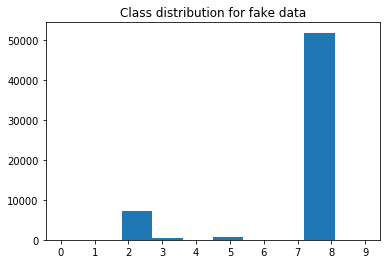

In [0]:
plt.xticks(np.arange(0, 10, step=1))
plt.title('Class distribution for fake data')
plt.hist(np.argmax(y_rand, axis=1))
plt.show()

In [0]:
np.sum(np.argmax(y_rand, axis=1) == 9)

17

In [0]:
import tensorflow as tf
import datetime, os
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight('balanced', np.unique(np.argmax(y_rand, axis=1)), np.argmax(y_rand, axis=1), )
class_weights

array([9.52380952e+02, 9.42018746e-01, 1.30208333e+01, 3.70370370e+02,
       1.13960114e+01, 3.70370370e+02, 4.76190476e+02, 1.28819498e-01,
       3.92156863e+02])

In [0]:
'''Trains a simple convnet on the MNIST dataset.

Gets to 99.25% test accuracy after 12 epochs
(there is still a lot of margin for parameter tuning).
16 seconds per epoch on a GRID K520 GPU.
'''

from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

batch_size = 128
num_classes = 10
epochs = 12

# input image dimensions
img_rows, img_cols = 28, 28

# the data, split between train and test sets
#(x_train, y_train) = (pixel_batch, pix_softmax_lin)
(x_train, y_train) = (x_rand, y_rand)

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')


# convert class vectors to binary class matrices
#y_train = keras.utils.to_categorical(y_train, num_classes)
#y_test = keras.utils.to_categorical(y_test, num_classes)

model_steal = Sequential()
model_steal.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model_steal.add(Conv2D(64, (3, 3), activation='relu'))
model_steal.add(MaxPooling2D(pool_size=(2, 2)))
#model_steal.add(Dropout(0.25))
model_steal.add(Flatten())
model_steal.add(Dense(128, activation='relu'))
#model_steal.add(Dropout(0.5))
model_steal.add(Dense(num_classes, activation='softmax'))


logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir)

model_steal.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

model_steal.fit(x_train, y_train,
               batch_size=batch_size,
               epochs=10,
               verbose=1,
               validation_data=(x_test, y_test), 
               class_weight=class_weights,
               callbacks=[tensorboard_callback])


score = model_steal.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])


x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples
Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 5s 79us/step - loss: 0.4894 - acc: 0.8637 - val_loss: 2.3222 - val_acc: 0.2150
Epoch 2/10
60000/60000 [==============================] - 4s 72us/step - loss: 0.3175 - acc: 0.8999 - val_loss: 2.6069 - val_acc: 0.2622
Epoch 3/10
60000/60000 [==============================] - 4s 72us/step - loss: 0.2504 - acc: 0.9223 - val_loss: 2.4331 - val_acc: 0.3334
Epoch 4/10
60000/60000 [==============================] - 4s 72us/step - loss: 0.2241 - acc: 0.9359 - val_loss: 2.2099 - val_acc: 0.3524
Epoch 5/10
60000/60000 [==============================] - 4s 72us/step - loss: 0.2088 - acc: 0.9429 - val_loss: 2.2479 - val_acc: 0.3446
Epoch 6/10
60000/60000 [==============================] - 4s 72us/step - loss: 0.1971 - acc: 0.9497 - val_loss: 2.2378 - val_acc: 0.3452
Epoch 7/10
60000/60000 [==============================]

In [0]:
plt.matshow(x_train[50000, :, :, 0])

In [0]:
from sklearn.metrics import confusion_matrix

y_pred = model_steal.predict(x_test)

matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
plt.matshow(matrix)
plt.colorbar()
plt.show()

In [0]:
from itertools import cycle
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

n_classes = 10
# For each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test[:, i],
                                                        y_pred[:, i])
    average_precision[i] = average_precision_score(y_test[:, i], y_pred[:, i])

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(y_test.ravel(),
    y_pred.ravel())
average_precision["micro"] = average_precision_score(y_test, y_pred,
                                                     average="micro")
print('Average precision score, micro-averaged over all classes: {0:0.2f}'
      .format(average_precision["micro"]))



plt.figure(figsize=(10, 10))
plt.step(recall['micro'], precision['micro'], color='b', alpha=0.2,
         where='post')
plt.fill_between(recall["micro"], precision["micro"], alpha=0.2, color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title(
    'Average precision score, micro-averaged over all classes: AP={0:0.2f}'
    .format(average_precision["micro"]))



# setup plot details
colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal'])

plt.figure(figsize=(10, 10))
f_scores = np.linspace(0.2, 0.8, num=4)
lines = []
labels = []
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
    plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))

lines.append(l)
labels.append('iso-f1 curves')
l, = plt.plot(recall["micro"], precision["micro"], color='gold', lw=2)
lines.append(l)
labels.append('micro-average Precision-recall (area = {0:0.2f})'
              ''.format(average_precision["micro"]))

for i, color in zip(range(n_classes), colors):
    l, = plt.plot(recall[i], precision[i], color=color, lw=2)
    lines.append(l)
    labels.append('Precision-recall for class {0} (area = {1:0.2f})'
                  ''.format(i, average_precision[i]))

fig = plt.gcf()
fig.subplots_adjust(bottom=0.25)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Extension of Precision-Recall curve to multi-class')
plt.legend(lines, labels, loc=(0, -.38), prop=dict(size=14))


plt.show()

In [0]:
(x_train_tmp, y_train_tmp), (x_test_tmp, y_test_tmp) = mnist.load_data()

In [0]:
n_pix_i = []

for i in range(10):
  n_pix_i.append([np.sum(x) for x in x_train_tmp[(y_train_tmp == i)] / 255.0])
  plt.hist(n_pix_i[-1], label='{}'.format(i))
  
plt.title('Pixel count distributions per class')
plt.legend()
plt.show()